In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
import csv
import os
import networkx as nx
import matplotlib.pyplot as plt
import random
import csv
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = "/content/drive/MyDrive/MLNS/Group_Project/data"
os.path.isdir(data_dir)

True

# Project Presentation

In this project, we aim to realize automatic toxic subreddit moderation. 
The dataset we decide to work with is taken from [Social Network: Reddit Hyperlink Network](https://snap.stanford.edu/data/soc-RedditHyperlinks.html). It contains inter-subreddit posts from 2014 to 2017 which are labelled in binary. The label is 1 when the post is considered positive and 0 when considered negative towards the target subreddit.

We position ourselves from Reddit's point-of-view and consider they would like to identify potentially harmful subreddits. That is, subreddits which are excessively negative towards other subreddits. We decide to follow the following steps:

* Using data from 2014 to 2016, we will build a model which predicts the activity between subreddits in 2017 (data started being recorded at the end of 2013 thus is difficult to exploit). To do so, we will make use of 2 types of features: Graph based features and Subreddit information features. Note that our model is time dependent. Thus, features must be built based on information available from the past. For each year, we will build features based on the graph and subreddit state of the previous year. Therefore, interactions from 2014 will define prediction data for 2015 and so on.

* Based on the predictions of the previous model, we will obtain a graph of positive and negative interactions between subreddits in 2017. We will then analyze this graph using PageRank and define a method to extract harmful groups.

# Data Preparation

### Data Import

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/MLNS/Group_Project/data/soc-redditHyperlinks-body.tsv",sep="\t")
df["TIMESTAMP"] = pd.to_datetime(df["TIMESTAMP"])
df["YEAR"] = df["TIMESTAMP"].dt.year

# Remove data from 2013
df = df[df["YEAR"] >= 2014]

In [ ]:
# Expand PROPERTIES column into several feature columns
post_properties = ["nb_chars","nb_chars_nospace","alph_chars","dgt_frac","upp_case","wht_spaces","special_chars","nb_words",
                    "nb_words_unq","nb_long_words","avg_word_lgt","unq_stpwords","stpwords_frac","nb_sentences","nb_long_sentences",
                    "chars_per_sent","words_per_sent","readability_index","VADER_pos","VADER_neg","VADER_compound",
                    "LIWC_Funct","LIWC_Pronoun","LIWC_Ppron","LIWC_I","LIWC_We","LIWC_You","LIWC_SheHe","LIWC_They","LIWC_Ipron","LIWC_Article","LIWC_Verbs",
                    "LIWC_AuxVb","LIWC_Past","LIWC_Present","LIWC_Future","LIWC_Adverbs","LIWC_Prep","LIWC_Conj","LIWC_Negate","LIWC_Quant","LIWC_Numbers",
                    "LIWC_Swear","LIWC_Social","LIWC_Family","LIWC_Friends","LIWC_Humans","LIWC_Affect","LIWC_Posemo","LIWC_Negemo","LIWC_Anx","LIWC_Anger",
                    "LIWC_Sad","LIWC_CogMech","LIWC_Insight","LIWC_Cause","LIWC_Discrep","LIWC_Tentat","LIWC_Certain","LIWC_Inhib","LIWC_Incl","LIWC_Excl",
                    "LIWC_Percept","LIWC_See","LIWC_Hear","LIWC_Feel","LIWC_Bio","LIWC_Body","LIWC_Health","LIWC_Sexual","LIWC_Ingest","LIWC_Relativ",
                    "LIWC_Motion","LIWC_Space","LIWC_Time","LIWC_Work","LIWC_Achiev","LIWC_Leisure","LIWC_Home","LIWC_Money","LIWC_Relig","LIWC_Death",
                    "LIWC_Assent","LIWC_Dissent","LIWC_Nonflu","LIWC_Filler"]

df[post_properties] = df['PROPERTIES'].str.split(',', 86, expand=True)
df[post_properties] = df[post_properties].astype(float)
df = df.drop(columns=['PROPERTIES'])

In [ ]:
df.dtypes

SOURCE_SUBREDDIT            object
TARGET_SUBREDDIT            object
POST_ID                     object
TIMESTAMP           datetime64[ns]
LINK_SENTIMENT               int64
                         ...      
LIWC_Death                 float64
LIWC_Assent                float64
LIWC_Dissent               float64
LIWC_Nonflu                float64
LIWC_Filler                float64
Length: 92, dtype: object

### Feature Engineering

Our prediction data is defined by a source node, a target node, a year and its features, the labels are the number of positive and negative interactions during that year.

In [ ]:
# Only take columns which will be final
df_keys = df[["SOURCE_SUBREDDIT","TARGET_SUBREDDIT","YEAR","LINK_SENTIMENT"]]
# Create two columns for positive and negative interactions
df_keys["POSITIVE_SENTIMENT"] = np.maximum(0,df_keys["LINK_SENTIMENT"])
df_keys["NEGATIVE_SENTIMENT"] = np.minimum(0,df_keys["LINK_SENTIMENT"])
df_keys = df_keys.drop(columns=["LINK_SENTIMENT"])

# Group rows by key (source,target,year) and sum positive and negative interactions
df_keys = df_keys.groupby(["SOURCE_SUBREDDIT","TARGET_SUBREDDIT","YEAR"]).sum().reset_index()

In [ ]:
df_keys

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,YEAR,POSITIVE_SENTIMENT,NEGATIVE_SENTIMENT
0,07scape,osrstranscripts,2016,2,0
1,0magick,occult,2015,1,0
2,0x10c,ixion,2014,1,0
3,0x10c,techcompliant,2015,1,0
4,0x10c,techcompliant,2017,1,0
...,...,...,...,...,...
169047,zyramains,summonerschool,2015,1,0
169048,zyramains,summonerschool,2016,1,0
169049,zyramains,threshmains,2016,1,0
169050,zyzz,fitness,2014,1,0


##### Graph Based Features

We now build graph based features. Keep in mind that the features of an edge at year n will be computed using the data of year n-1. Thus, to compute features for year 2015, we build the graph using data from 2014 and so on. We will build the following list of features:

* Source and target node PageRank value.
* Preferential attachment, Jaccard coefficient and Adamic-Adar index.
* Number of common neighbours.
* In and out degree for each node.

Note that two graphs will be computed from the data. A graph obtained from negative interactions and another obtained from positive ones. The features mentionned above will thus be doubled each time.

In [ ]:
# Run through each year and compute graph features
df_final = None

for year in [2015,2016,2017]:
    print("Computing Graph features for year {}".format(year))

    # Access data from the previous year and compute corresponding nodes and edges
    df_year_past, df_year = df_keys[df_keys["YEAR"] == year-1], df_keys[df_keys["YEAR"] == year]
    nodes = set(list(df_year["SOURCE_SUBREDDIT"]) + list(df_year["TARGET_SUBREDDIT"])) # Set of nodes
    edges = list(zip(list(df_year["SOURCE_SUBREDDIT"]),list(df_year["TARGET_SUBREDDIT"]))) # List of all edges
    nodes_past = set(list(df_year_past["SOURCE_SUBREDDIT"]) + list(df_year_past["TARGET_SUBREDDIT"])) # Set of nodes from past year
    edges_past = list(zip(list(df_year_past["SOURCE_SUBREDDIT"]),list(df_year_past["TARGET_SUBREDDIT"]))) # List of all edges from past year
    edges_pos = list(zip(list(df_year_past[df_year_past["POSITIVE_SENTIMENT"] > 0]["SOURCE_SUBREDDIT"]),list(df_year_past[df_year_past["POSITIVE_SENTIMENT"] > 0]["TARGET_SUBREDDIT"]))) # List of positive edges from past year
    edges_neg = list(zip(list(df_year_past[df_year_past["NEGATIVE_SENTIMENT"] > 0]["SOURCE_SUBREDDIT"]),list(df_year_past[df_year_past["POSITIVE_SENTIMENT"] > 0]["TARGET_SUBREDDIT"]))) # List of negative edges from past year
    nodes_all = list(nodes.union(nodes_past)) # List of all nodes from current and past year

    # Build resulting directed graphs
    G_pos = nx.DiGraph()
    G_neg = nx.DiGraph()
    G_pos.add_nodes_from(nodes_all)
    G_neg.add_nodes_from(nodes_all)
    G_pos.add_edges_from(edges_pos)
    G_neg.add_edges_from(edges_neg)

    # Build corresponding undirected graphs
    G_pos_undir = nx.Graph(G_pos)
    G_neg_undir = nx.Graph(G_neg)

    # Compute pagerank
    pagerank_pos = nx.pagerank(G_pos)
    pagerank_neg = nx.pagerank(G_neg)

    df_year["pagerank_source_pos"] = df_year["SOURCE_SUBREDDIT"].apply(lambda x: pagerank_pos[x])
    df_year["pagerank_source_neg"] = df_year["SOURCE_SUBREDDIT"].apply(lambda x: pagerank_neg[x])
    df_year["pagerank_target_pos"] = df_year["TARGET_SUBREDDIT"].apply(lambda x: pagerank_pos[x])
    df_year["pagerank_target_neg"] = df_year["TARGET_SUBREDDIT"].apply(lambda x: pagerank_neg[x])

    # Compute similarity metrics
    # Preferential Attachment
    df_year["preferential_attachment_pos"] = [pa[2] for pa in nx.preferential_attachment(G_pos_undir, edges)]
    df_year["preferential_attachment_neg"] = [pa[2] for pa in nx.preferential_attachment(G_neg_undir, edges)]

    # Jaccard Similarity
    df_year["jaccard_pos"] = [pa[2] for pa in nx.jaccard_coefficient(G_pos_undir, edges)]
    df_year["jaccard_neg"] = [pa[2] for pa in nx.jaccard_coefficient(G_neg_undir, edges)]

    # Adamic-Adar Index
    df_year["adamic_adar_pos"] = [pa[2] for pa in nx.adamic_adar_index(G_pos_undir, edges)]
    df_year["adamic_adar_neg"] = [pa[2] for pa in nx.adamic_adar_index(G_neg_undir, edges)]

    # Compute in and out degrees
    df_year["in_degree_source_pos"] = df_year["SOURCE_SUBREDDIT"].apply(lambda x: G_pos.in_degree(x))
    df_year["out_degree_source_pos"] = df_year["SOURCE_SUBREDDIT"].apply(lambda x: G_pos.out_degree(x))
    df_year["in_degree_target_pos"] = df_year["TARGET_SUBREDDIT"].apply(lambda x: G_pos.in_degree(x))
    df_year["out_degree_target_pos"] = df_year["TARGET_SUBREDDIT"].apply(lambda x: G_pos.out_degree(x))

    df_year["in_degree_source_neg"] = df_year["SOURCE_SUBREDDIT"].apply(lambda x: G_neg.in_degree(x))
    df_year["out_degree_source_neg"] = df_year["SOURCE_SUBREDDIT"].apply(lambda x: G_neg.out_degree(x))
    df_year["in_degree_target_neg"] = df_year["TARGET_SUBREDDIT"].apply(lambda x: G_neg.in_degree(x))
    df_year["out_degree_target_neg"] = df_year["TARGET_SUBREDDIT"].apply(lambda x: G_neg.out_degree(x))

    # Compute number of common neighbour
    df_year["common_neigbours_pos"] = [len(list(nx.common_neighbors(G_pos_undir, edge[0], edge[1]))) for edge in edges]
    df_year["common_neigbours_neg"] = [len(list(nx.common_neighbors(G_neg_undir, edge[0], edge[1]))) for edge in edges]

    if df_final is None: df_final = df_year
    else: df_final = pd.concat([df_final,df_year])

Computing Graph features for year 2015
Computing Graph features for year 2016
Computing Graph features for year 2017


In [ ]:
# Check if number of rows is correct
print("Is number of rows correct:", len(df_keys[df_keys["YEAR"] >= 2015]) == len(df_final))

Is number of rows correct: True


In [ ]:
df_final

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,YEAR,POSITIVE_SENTIMENT,NEGATIVE_SENTIMENT,pagerank_source_pos,pagerank_source_neg,pagerank_target_pos,pagerank_target_neg,preferential_attachment_pos,...,in_degree_source_pos,out_degree_source_pos,in_degree_target_pos,out_degree_target_pos,in_degree_source_neg,out_degree_source_neg,in_degree_target_neg,out_degree_target_neg,common_neigbours_pos,common_neigbours_neg
1,0magick,occult,2015,1,0,0.000020,0.000044,0.000203,0.000044,0,...,0,0,11,16,0,0,0,0,0,0
3,0x10c,techcompliant,2015,1,0,0.000020,0.000044,0.000020,0.000044,0,...,0,2,0,0,0,0,0,0,0,0
9,100daysofketo,keto,2015,2,0,0.000026,0.000044,0.000277,0.000044,46,...,1,0,18,38,0,0,0,0,0,0
12,100daysofketo,xxketo,2015,1,0,0.000026,0.000044,0.000050,0.000044,6,...,1,0,3,5,0,0,0,0,1,0
20,100movies365days,truefilm,2015,1,0,0.000039,0.000044,0.000116,0.000044,77,...,1,6,7,4,0,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169009,zootopia,place,2017,2,0,0.000118,0.000043,0.000016,0.000043,0,...,6,9,0,0,0,0,0,0,0,0
169013,zootopia,thefinalclean,2017,1,0,0.000118,0.000043,0.000016,0.000043,0,...,6,9,0,0,0,0,0,0,0,0
169014,zootopia,whowouldwin,2017,1,0,0.000118,0.000043,0.000660,0.000043,600,...,6,9,50,0,0,0,0,0,0,0
169017,zotac,nvidia,2017,1,0,0.000016,0.000043,0.000490,0.000043,0,...,0,0,30,25,0,0,0,0,0,0


Note that we made the intentional choice not to use the number of positive and negative interactions of the previous year as a feature. Indeed, though this would be causal, because, at the end of 2016, posts of 2016 have been made and can thus be used as information for predicting in 2017, this would be counter to the point of our project. Indeed, we intend to propose an automated tool to target potentially harmful Subreddits. Therefore, we aim to use features that can themselves be computed automatically. Unfortunately, using the POSITIVE_SENTIMENT and NEGATIVE_SENTIMENT attributes would imply yearly, manual labelling work. We thus decide to omit them, though they would bring valuable information to the model. 

A good compromise will be to use the VADER features our dataset contains. VADER is a sentiment analysis tool able to quantify the sentiments of a text. Therefore, information about post sentiments will be contained in these features.

##### Node-Wise Features

We now build features related to the behaviour of subreddits themselves. To do so, we intend to use the post property attributes contained in the original dataset. These attributes were computed to characterize the posts of the corresponding row (e.g. number of characters, words, sentences, sentiment analysis coefficients computed by VADER and word counts computed according to the LIWC standards). If aggregated per Subreddit, these attributes can characterize the behaviour of Subreddits in general. Typically, the number of words per post, when aggregated, becomes the average number of words a Subreddit contains. Note one important thing:
* There are a total of 86 post attributes. If we decide to use all these attributes for both of the Subreddits of a link, we will have an additional 172 attributes. This seems quite extensive and probably unnecessary so we will attempt to find the best compromise between number of features and model performance. In a first attempt we will use the post attributes for the source Subreddit only as we attempt to predict whether this Subreddit will write a post about the other. But we may also try to reduce the number of post attributes and use them for both nodes of the link.


In [ ]:
# Consider columns of interest
columns = ["SOURCE_SUBREDDIT","YEAR"] + post_properties
df_features = df[columns]

In [ ]:
# Offset YEAR value by 1 for future merge with the final dataframe (attributes of year n are computed from year n-1)
df_features["YEAR"] = df_features["YEAR"] + 1

In [ ]:
# Group by source, target and year and average the rest of the features
df_features = df_features.groupby(["SOURCE_SUBREDDIT","YEAR"]).mean().reset_index()

In [ ]:
# Join feature data to the final DataFrame
df_final = pd.merge(df_final, df_features, how="left", on=["SOURCE_SUBREDDIT","YEAR"])

In [ ]:
# Count NULL values
df_final.isna().sum()

SOURCE_SUBREDDIT          0
TARGET_SUBREDDIT          0
YEAR                      0
POSITIVE_SENTIMENT        0
NEGATIVE_SENTIMENT        0
                      ...  
LIWC_Death            33260
LIWC_Assent           33260
LIWC_Dissent          33260
LIWC_Nonflu           33260
LIWC_Filler           33260
Length: 111, dtype: int64

The number of missing values in the data is considerable. This essentially means that a lot of existing links were created from Subreddits that did not interact in the previous year at all. We analyze the distribution of target variables for rows with missing values.

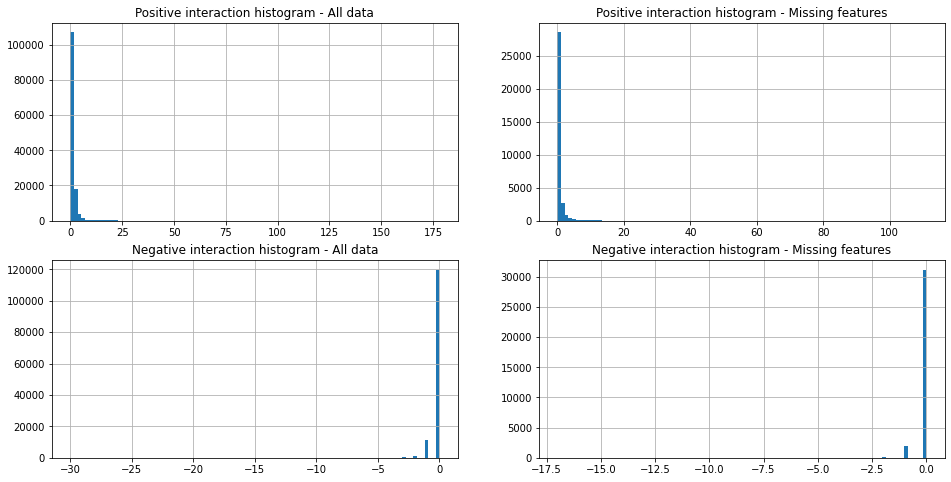

In [ ]:
# Filter through rows with missing values and plot histograms
df_nans = df_final[df_final["nb_words"].isna()]

fig, axs = plt.subplots(2,2, figsize=(16,8))

axs[0,0].set_title("Positive interaction histogram - All data")
df_final["POSITIVE_SENTIMENT"].hist(bins=100, ax=axs[0,0])

axs[0,1].set_title("Positive interaction histogram - Missing features")
df_nans["POSITIVE_SENTIMENT"].hist(bins=100, ax=axs[0,1])

axs[1,0].set_title("Negative interaction histogram - All data")
df_final["NEGATIVE_SENTIMENT"].hist(bins=100, ax=axs[1,0])

axs[1,1].set_title("Negative interaction histogram - Missing features")
df_nans["NEGATIVE_SENTIMENT"].hist(bins=100, ax=axs[1,1])

plt.show()

Distributions when looking at all data and missing features data are very similar. We can thus anticipate having all those missing values will be an issue in predicting accurately. For the moment, we replace all missing values by 0 as it translates the absence of activity from the Subreddit. We will consider more complex solutions if this is inconclusive.

In [ ]:
df_final = df_final.fillna(0)

### Interaction Prediction Models

Given the dataset prepared in the sections above, we now aim to train models for positive and negative interactions. We will implement different models and compare them to obtain the best results.

First, we split our data into train, validation and test sets. Our train set will be the entire samples from 2015 and 2016 while validation and test sets will be taken from 2017 data.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score

In [ ]:
# Split into train, validation and test sets
df_train, df_val_test = df_final[df_final["YEAR"] < 2017], df_final[df_final["YEAR"] == 2017]
df_val, df_test = train_test_split(df_val_test, test_size=0.5, random_state=42) # Split equally between validation and test sets

In [ ]:
# Get labels and features and prepare data for training
features = ["pagerank_source_pos","pagerank_source_neg","pagerank_target_pos","pagerank_target_neg",
            "preferential_attachment_pos","preferential_attachment_neg","jaccard_pos","jaccard_neg",
            "adamic_adar_pos","adamic_adar_neg","in_degree_source_pos","out_degree_source_pos","in_degree_target_pos",
            "out_degree_target_pos","in_degree_source_neg","out_degree_source_neg","in_degree_target_neg",
            "out_degree_target_neg","common_neigbours_pos","common_neigbours_neg"] + post_properties
labels = ["POSITIVE_SENTIMENT","NEGATIVE_SENTIMENT"]

X_train, y_train = df_train[features], df_train[labels]
X_val, y_val = df_val[features], df_val[labels]
X_test, y_test = df_test[features], df_test[labels]

##### Catboost

We first train a Catboost Regression model on our data.

In [ ]:
!pip install catboost

     |████████████████████████████████| 76.1 MB 1.3 MB/s 


In [ ]:
import catboost as cb

In [ ]:
# Prepare data and model for training
train_pool, val_pool, test_pool = cb.Pool(X_train,y_train), cb.Pool(X_val,y_val), cb.Pool(X_test,y_test)
model = cb.CatBoostRegressor(loss_function="MultiRMSE")

In [ ]:
# Train using GridSearch
grid = {'iterations': [200],
        'learning_rate': [0.03, 0.1],
        'depth': [6, 8],
        'l2_leaf_reg': [0.2, 0.5]}

model.grid_search(grid, train_pool)

0:	learn: 3.4765864	test: 3.1835605	best: 3.1835605 (0)	total: 153ms	remaining: 30.5s
1:	learn: 3.4538557	test: 3.1591941	best: 3.1591941 (1)	total: 257ms	remaining: 25.5s
2:	learn: 3.4299210	test: 3.1348687	best: 3.1348687 (2)	total: 348ms	remaining: 22.9s
3:	learn: 3.4080798	test: 3.1117730	best: 3.1117730 (3)	total: 465ms	remaining: 22.8s
4:	learn: 3.3870011	test: 3.0896978	best: 3.0896978 (4)	total: 567ms	remaining: 22.1s
5:	learn: 3.3679201	test: 3.0702135	best: 3.0702135 (5)	total: 662ms	remaining: 21.4s
6:	learn: 3.3496264	test: 3.0509491	best: 3.0509491 (6)	total: 775ms	remaining: 21.4s
7:	learn: 3.3313358	test: 3.0321091	best: 3.0321091 (7)	total: 906ms	remaining: 21.8s
8:	learn: 3.3136811	test: 3.0133969	best: 3.0133969 (8)	total: 1.08s	remaining: 23s
9:	learn: 3.2976089	test: 2.9972046	best: 2.9972046 (9)	total: 1.21s	remaining: 22.9s
10:	learn: 3.2814602	test: 2.9799077	best: 2.9799077 (10)	total: 1.31s	remaining: 22.6s
11:	learn: 3.2663032	test: 2.9647322	best: 2.9647322 (

{'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
               48,
               49,
             

Global RMSE: 1.6946
Positive Sentiment RMSE: 2.3566
Negative Sentiment RMSE: 2.8155

Positive Sentiment Accuracy: 0.5452
Negative Sentiment Accuracy: 0.8568


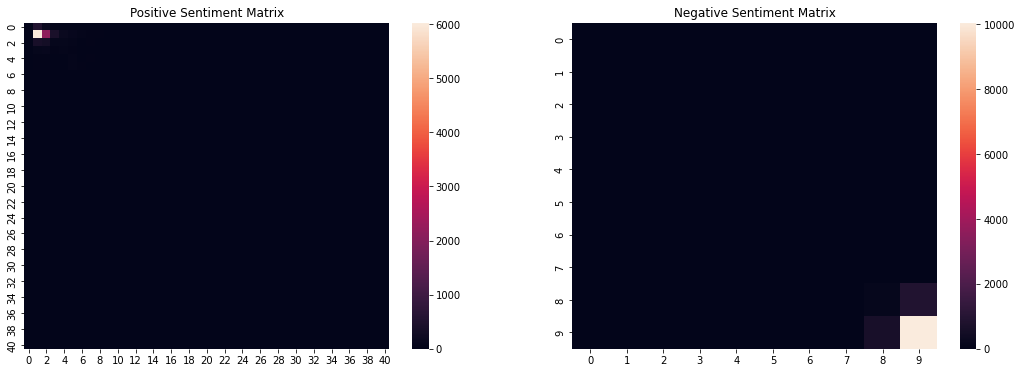

In [ ]:
# Evaluate model on test data

# Compute RMSE
pred = model.predict(test_pool)
rmse = np.sqrt(mean_squared_error(y_test, pred))
rmse_pos = np.sqrt(mean_squared_error(y_test["POSITIVE_SENTIMENT"],pred[:,0]))
rmse_neg = np.sqrt(mean_squared_error(y_test["NEGATIVE_SENTIMENT"],pred[:,0]))
print("Global RMSE:",round(rmse,4))
print("Positive Sentiment RMSE:",round(rmse_pos,4))
print("Negative Sentiment RMSE:",round(rmse_neg,4))
print()

# Compute Accuracy
pred_int = np.round_(pred) # Round prediction to the nearest integer
accuracy_pos = accuracy_score(y_test["POSITIVE_SENTIMENT"], pred_int[:,0])
accuracy_neg = accuracy_score(y_test["NEGATIVE_SENTIMENT"], pred_int[:,1])
print("Positive Sentiment Accuracy:",round(accuracy_pos,4))
print("Negative Sentiment Accuracy:",round(accuracy_neg,4))

# Plot Confusion Matrices
confusion_mtx_pos = confusion_matrix(y_test["POSITIVE_SENTIMENT"].to_numpy(), pred_int[:,0])
confusion_mtx_neg = confusion_matrix(y_test["NEGATIVE_SENTIMENT"].to_numpy(), pred_int[:,1])

fig, axs = plt.subplots(1,2,figsize=(18,6))

axs[0].set_title("Positive Sentiment Matrix")
sns.heatmap(confusion_mtx_pos, annot=False, ax=axs[0])

axs[1].set_title("Negative Sentiment Matrix")
sns.heatmap(confusion_mtx_neg, annot=False, ax=axs[1])

plt.show()

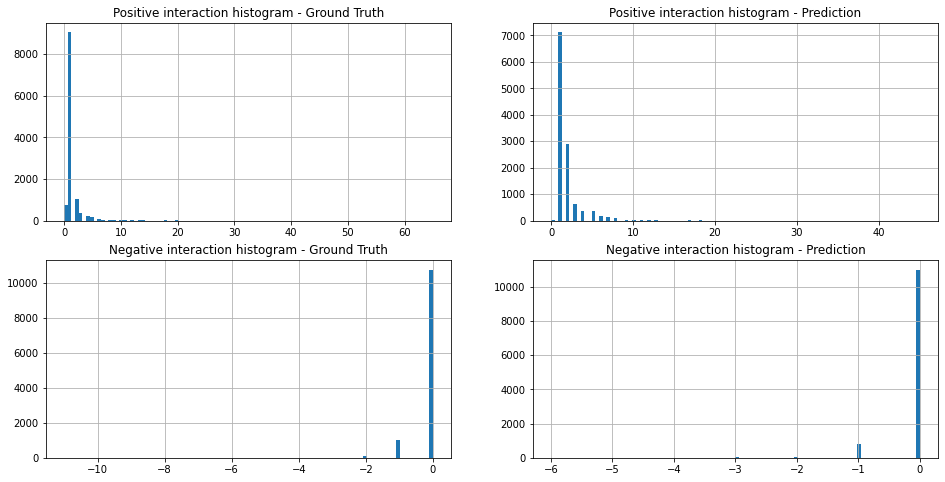

In [ ]:
# Plot histograms to compare ground truth distributions to prediction ones
y_test["POSITIVE_SENTIMENT_pred"] = pred_int[:,0]
y_test["NEGATIVE_SENTIMENT_pred"] = pred_int[:,1]

fig, axs = plt.subplots(2,2, figsize=(16,8))

axs[0,0].set_title("Positive interaction histogram - Ground Truth")
y_test["POSITIVE_SENTIMENT"].hist(bins=100, ax=axs[0,0])

axs[0,1].set_title("Positive interaction histogram - Prediction")
y_test["POSITIVE_SENTIMENT_pred"].hist(bins=100, ax=axs[0,1])

axs[1,0].set_title("Negative interaction histogram - Ground Truth")
y_test["NEGATIVE_SENTIMENT"].hist(bins=100, ax=axs[1,0])

axs[1,1].set_title("Negative interaction histogram - Prediction")
y_test["NEGATIVE_SENTIMENT_pred"].hist(bins=100, ax=axs[1,1])

plt.show()

We observe quite equally distributed predictions compared to ground truth values. In terms of positive interactions, our model tends to predict more than the ground truth (the confusion matrix is subdiagonal). The distribution in negative interactions in terms of predicted and ground truth values are relatively similar. The model struggles to predict high values of negative interactions simply because the dataset lacks in those labels. We must note two important things in the interpretation of these results:
* 2017 ground truth data is biased. Indeed, the dataset contains records up to April 2017, thus the 2017 year isn't complete. Therefore, all labels are sub-approximated. This means comparing our predictions to the 2017 ground truth data is not a great indicator of the model's performance. It rather gives a sensible approximation to the actual generalization error. In order to get an idea of model performance, it would be sensible to compute ground truth distribution of labels for years during which data racording is complete. We can then assume that interactions between subreddits are similiar in behaviour throughout the years, thus our predicted distribution of 2017 should be similar to the ones of 2015 and 2016.
* We observe that the model has trouble predicting 0s in positive interactions. This is once again caused by the lack of balance in our labeled data. In fact, data was computed from links that had interactions (either positive or negative). Thus, each row of data contains a non-null value in at least one of the two target variables. In practice, we observe that there is a clear lack of rows without a vanishing positive interaction. This explains why our model has difficulties in predicting them. We have tried to generate random inexisting links in our graph structure to balance equally between non-null labels and null labels. But the methods attempted to generate non-existing links have proven too complex in space for the allocated memory we have access to.

##### Pytorch

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional  as F
import torch.optim as optim

In [ ]:
# Normalize features
"""
X = pd.concat([X_train,X_val,X_test]) # Take all data for normalization constants

for feature in features:
    X_train[feature] = (X_train[feature] - X[feature].mean()) / X[feature].std()
    X_val[feature] = (X_val[feature] - X[feature].mean()) / X[feature].std()
    X_test[feature] = (X_test[feature] - X[feature].mean()) / X[feature].std()
"""
# Remark: we find that normalizing when a considerable amount of data is 0s is unhelpful and counter-productive

'\nX = pd.concat([X_train,X_val,X_test]) # Take all data for normalization constants\n\nfor feature in features:\n    X_train[feature] = (X_train[feature] - X[feature].mean()) / X[feature].std()\n    X_val[feature] = (X_val[feature] - X[feature].mean()) / X[feature].std()\n    X_test[feature] = (X_test[feature] - X[feature].mean()) / X[feature].std()\n'

In [ ]:
# Build dataset
train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_train.to_numpy().astype(np.float32)), torch.from_numpy(y_train.to_numpy().astype(np.float32)))
val_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_val.to_numpy().astype(np.float32)), torch.from_numpy(y_val.to_numpy().astype(np.float32)))
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_test.to_numpy().astype(np.float32)), torch.from_numpy(y_test.to_numpy().astype(np.float32)))

# Build Dataloader
batch_size = 1024
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=len(test_dataset))

In [ ]:
# Build model
class MultiRegressor(nn.Module):
    def __init__(self, depth, neurons, input_size):
        super().__init__()
        self.module_list = nn.ModuleList()
        self.module_list.append(nn.Linear(input_size,neurons))
        for i in range(1,depth-1):
            self.module_list.append(nn.Linear(neurons,neurons))
        self.positive_sent = nn.Linear(neurons,1)
        self.negative_sent = nn.Linear(neurons,1)

    def forward(self, x):
        for layer in self.module_list:
            x = nn.ReLU()(layer(x))
        x_pos = nn.ReLU()(self.positive_sent(x))
        x_neg = -nn.ReLU()(self.negative_sent(x))
        return x_pos,x_neg

In [ ]:
model = MultiRegressor(6,10,106)
model

MultiRegressor(
  (module_list): ModuleList(
    (0): Linear(in_features=106, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): Linear(in_features=10, out_features=10, bias=True)
  )
  (positive_sent): Linear(in_features=10, out_features=1, bias=True)
  (negative_sent): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
criterion = nn.MSELoss()
accuracy = accuracy_score
optimizer = optim.Adam(model.parameters())
epochs = 250
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model.to(device)

MultiRegressor(
  (module_list): ModuleList(
    (0): Linear(in_features=106, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): Linear(in_features=10, out_features=10, bias=True)
  )
  (positive_sent): Linear(in_features=10, out_features=1, bias=True)
  (negative_sent): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
train_loss, train_accuracy_pos, train_accuracy_neg = [], [], []
val_loss, val_accuracy_pos, val_accuracy_neg = [], [], []
model_state_dict, best_accuracy, best_epoch = None,0,None

for epoch in range(epochs):

    # Train
    epoch_loss, epoch_accuracy_pos, epoch_accuracy_neg = 0,0,0
    model.train()
    for x,y in train_loader:
        input_, label_ = x.to(device), y.to(device)
        
        # Make prediction
        pred_pos,pred_neg = model(input_)
        pred_pos,pred_neg = pred_pos.reshape(-1),pred_neg.reshape(-1)
        
        # Compute loss and accuracy
        loss_pos = criterion(pred_pos,label_[:,0])
        loss_neg = criterion(pred_neg,label_[:,1])
        loss = loss_pos + loss_neg
        optimizer.zero_grad()
        (loss_pos + loss_neg).backward()
        optimizer.step()

        accuracy_pos = accuracy(label_[:,0].detach().cpu(),torch.round(pred_pos).detach().cpu())
        accuracy_neg = accuracy(label_[:,1].detach().cpu(),torch.round(pred_neg).detach().cpu())

        epoch_loss += loss.item() * input_.shape[0] / len(train_dataset)
        epoch_accuracy_pos += accuracy_pos * input_.shape[0] / len(train_dataset)
        epoch_accuracy_neg += accuracy_neg * input_.shape[0] / len(train_dataset)

    print("Epoch {} - Train: Loss {} - Accuracy Pos {} - Accuracy Neg {}".format(epoch+1, round(epoch_loss,3), round(epoch_accuracy_pos,3), round(epoch_accuracy_neg,3)))
    train_loss.append(epoch_loss)
    train_accuracy_pos.append(epoch_accuracy_pos)
    train_accuracy_neg.append(epoch_accuracy_neg)

    # Validation
    epoch_loss, epoch_accuracy_pos, epoch_accuracy_neg = 0,0,0
    model.eval()
    for x,y in val_loader:
        input_, label_ = x.to(device), y.to(device)
        # Make prediction
        pred_pos, pred_neg = model(input_)
        pred_pos,pred_neg = pred_pos.reshape(-1),pred_neg.reshape(-1)

        # Compute loss and accuracy
        loss_pos = criterion(pred_pos,label_[:,0])
        loss_neg = criterion(pred_neg,label_[:,1])
        loss = loss_pos + loss_neg
        accuracy_pos = accuracy(label_[:,0].detach().cpu(),torch.round(pred_pos).detach().cpu())
        accuracy_neg = accuracy(label_[:,1].detach().cpu(),torch.round(pred_neg).detach().cpu())
        epoch_loss += loss.item() * input_.shape[0] / len(val_dataset)
        epoch_accuracy_pos += accuracy_pos * input_.shape[0] / len(val_dataset)
        epoch_accuracy_neg += accuracy_neg * input_.shape[0] / len(val_dataset)
    print("            Validation: Loss {} - Accuracy Pos {} - Accuracy Neg {}".format(round(epoch_loss,3), round(epoch_accuracy_pos,3), round(epoch_accuracy_neg,3)))
    val_loss.append(epoch_loss)
    val_accuracy_pos.append(epoch_accuracy_pos)
    val_accuracy_neg.append(epoch_accuracy_neg)

    # Check for best model
    if epoch_accuracy_pos + epoch_accuracy_neg >= best_accuracy:
        best_accuracy = epoch_accuracy_pos + epoch_accuracy_neg
        model_state_dict = model.state_dict().copy()
        best_epoch = epoch


# Come back to best model
model.load_state_dict(model_state_dict)

Epoch 1 - Train: Loss 13.142 - Accuracy Pos 0.28 - Accuracy Neg 0.89
            Validation: Loss 5.148 - Accuracy Pos 0.369 - Accuracy Neg 0.89
Epoch 2 - Train: Loss 9.959 - Accuracy Pos 0.457 - Accuracy Neg 0.896
            Validation: Loss 4.593 - Accuracy Pos 0.595 - Accuracy Neg 0.89
Epoch 3 - Train: Loss 9.585 - Accuracy Pos 0.562 - Accuracy Neg 0.898
            Validation: Loss 4.285 - Accuracy Pos 0.677 - Accuracy Neg 0.913
Epoch 4 - Train: Loss 9.328 - Accuracy Pos 0.558 - Accuracy Neg 0.899
            Validation: Loss 4.138 - Accuracy Pos 0.653 - Accuracy Neg 0.913
Epoch 5 - Train: Loss 9.266 - Accuracy Pos 0.519 - Accuracy Neg 0.9
            Validation: Loss 4.182 - Accuracy Pos 0.65 - Accuracy Neg 0.913
Epoch 6 - Train: Loss 9.317 - Accuracy Pos 0.532 - Accuracy Neg 0.899
            Validation: Loss 4.139 - Accuracy Pos 0.635 - Accuracy Neg 0.913
Epoch 7 - Train: Loss 9.255 - Accuracy Pos 0.515 - Accuracy Neg 0.901
            Validation: Loss 4.159 - Accuracy Pos 0.65

<All keys matched successfully>

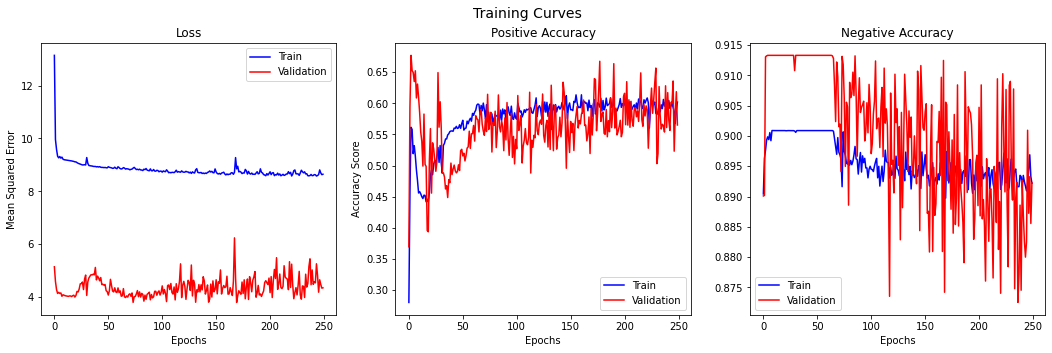

In [ ]:
# Plot training curves
fig, axs = plt.subplots(1,3,figsize=(18,5))

fig.suptitle("Training Curves", fontsize=14)

axs[0].set_title("Loss")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Mean Squared Error")
axs[0].plot(train_loss, c='b', label='Train')
axs[0].plot(val_loss, c='r', label='Validation')
axs[0].legend()

axs[1].set_title("Positive Accuracy")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy Score")
axs[1].plot(train_accuracy_pos, c='b', label='Train')
axs[1].plot(val_accuracy_pos, c='r', label='Validation')
axs[1].legend()

axs[2].set_title("Negative Accuracy")
axs[2].set_xlabel("Epochs")
axs[2].plot(train_accuracy_neg, c='b', label='Train')
axs[2].plot(val_accuracy_neg, c='r', label='Validation')
axs[2].legend()

plt.show()

From this training we observe several things:
* Training is extremely noisy. Though it is smooth on training data, the models performance on validation data oscillates extensively. This can be due to a couple of things: the difficulty of the model and the lack of data in the validation set. Indeed, the model contains several features and the problem at hand seems complicated to solve, thus it makes sense for the training to also be difficult. Moreover, remember that validation and test data are taken from 2017 where our dataset isn't complete. Therefore, ground truth data is biased and comparing our predictions to it does not make a great indicator for model generalization.
* Training one model for multiple target values does not seem to be a good idea. Indeed, as we are training on the sum of mean squared errors for positive and negative sentiment targets, the model seems to be making a compromise between predicting well on positive sentiments and negative sentiments. In fact, while the accuracy on positive sentiments increases over epochs, it seems to decrease for negative sentiments. This suggests two seperate models should be trained for each task.

In [ ]:
# Build positive and negative models
class PosRegressor(nn.Module):
    def __init__(self, depth, neurons, input_size):
        super().__init__()
        self.module_list = nn.ModuleList()
        self.module_list.append(nn.Linear(input_size,neurons))
        for i in range(1,depth-1):
            self.module_list.append(nn.Linear(neurons,neurons))
        self.output = nn.Linear(neurons,1)

    def forward(self, x):
        for layer in self.module_list:
            x = nn.ReLU()(layer(x))
        x = nn.ReLU()(self.output(x))
        return x

class NegRegressor(nn.Module):
    def __init__(self, depth, neurons, input_size):
        super().__init__()
        self.module_list = nn.ModuleList()
        self.module_list.append(nn.Linear(input_size,neurons))
        for i in range(1,depth-1):
            self.module_list.append(nn.Linear(neurons,neurons))
        self.output = nn.Linear(neurons,1)

    def forward(self, x):
        for layer in self.module_list:
            x = nn.ReLU()(layer(x))
        x = -nn.ReLU()(self.output(x))
        return x

In [ ]:
model_pos = PosRegressor(6,10,106)
model_neg = NegRegressor(6,10,106)

In [ ]:
criterion = nn.MSELoss()
accuracy_fct = accuracy_score
optimizer_pos = optim.Adam(model_pos.parameters())
optimizer_neg = optim.Adam(model_neg.parameters())
epochs = 250
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model_pos.to(device)
model_neg.to(device)

NegRegressor(
  (module_list): ModuleList(
    (0): Linear(in_features=106, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): Linear(in_features=10, out_features=10, bias=True)
  )
  (output): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# Train Positive Model
train_loss, train_accuracy = [], []
val_loss, val_accuracy = [], []
model_state_dict, best_accuracy, best_epoch = None,0,None

for epoch in range(epochs):

    # Train
    epoch_loss, epoch_accuracy = 0,0
    model_pos.train()
    for x,y in train_loader:
        input_, label_ = x.to(device), y[:,0].to(device)

        # Make prediction
        pred_ = model_pos(input_)
        pred_ = pred_.reshape(-1)
        
        # Compute loss and accuracy
        loss = criterion(pred_,label_)
        optimizer_pos.zero_grad()
        loss.backward()
        optimizer_pos.step()
        accuracy = accuracy_fct(label_.detach().cpu(),torch.round(pred_).detach().cpu())
        epoch_loss += loss.item() * input_.shape[0] / len(train_dataset)
        epoch_accuracy += accuracy * input_.shape[0] / len(train_dataset)
    print("Epoch {} - Train: Loss {} - Accuracy {}".format(epoch+1, round(epoch_loss,3), round(epoch_accuracy,3)))
    train_loss.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)

    # Validation
    epoch_loss, epoch_accuracy = 0,0
    model_pos.eval()
    for x,y in val_loader:
        input_, label_ = x.to(device), y[:,0].to(device)
        # Make prediction
        pred_ = model_pos(input_)
        pred_ = pred_.reshape(-1)

        # Compute loss and accuracy
        loss = criterion(pred_,label_)
        accuracy = accuracy_fct(label_.detach().cpu(),torch.round(pred_).detach().cpu())
        epoch_loss += loss.item() * input_.shape[0] / len(val_dataset)
        epoch_accuracy += accuracy * input_.shape[0] / len(val_dataset)
    print("            Validation: Loss {} - Accuracy {}".format(round(epoch_loss,3), round(epoch_accuracy,3)))
    val_loss.append(epoch_loss)
    val_accuracy.append(epoch_accuracy)

    # Check for best model
    if epoch_accuracy >= best_accuracy:
        best_accuracy = epoch_accuracy
        model_state_dict = model_pos.state_dict().copy()
        best_epoch = epoch

# Come back to best model
model_pos.load_state_dict(model_state_dict)

Epoch 1 - Train: Loss 10.034 - Accuracy 0.345
            Validation: Loss 4.682 - Accuracy 0.315
Epoch 2 - Train: Loss 9.598 - Accuracy 0.462
            Validation: Loss 4.316 - Accuracy 0.599
Epoch 3 - Train: Loss 9.319 - Accuracy 0.537
            Validation: Loss 4.026 - Accuracy 0.669
Epoch 4 - Train: Loss 9.136 - Accuracy 0.579
            Validation: Loss 4.036 - Accuracy 0.517
Epoch 5 - Train: Loss 9.038 - Accuracy 0.542
            Validation: Loss 4.164 - Accuracy 0.529
Epoch 6 - Train: Loss 8.969 - Accuracy 0.515
            Validation: Loss 4.139 - Accuracy 0.514
Epoch 7 - Train: Loss 8.943 - Accuracy 0.5
            Validation: Loss 4.053 - Accuracy 0.578
Epoch 8 - Train: Loss 8.927 - Accuracy 0.492
            Validation: Loss 4.046 - Accuracy 0.544
Epoch 9 - Train: Loss 9.071 - Accuracy 0.489
            Validation: Loss 5.062 - Accuracy 0.484
Epoch 10 - Train: Loss 9.423 - Accuracy 0.548
            Validation: Loss 4.563 - Accuracy 0.641
Epoch 11 - Train: Loss 9.151 -

<All keys matched successfully>

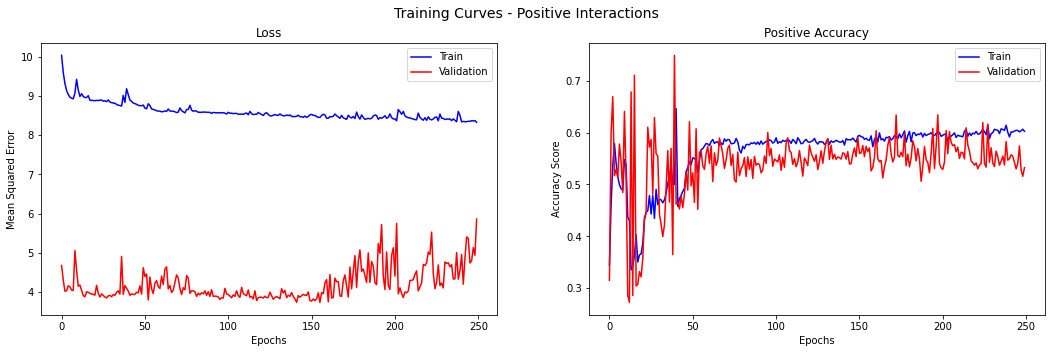

In [ ]:
# Plot training curves
fig, axs = plt.subplots(1,2,figsize=(18,5))

fig.suptitle("Training Curves - Positive Interactions", fontsize=14)

axs[0].set_title("Loss")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Mean Squared Error")
axs[0].plot(train_loss, c='b', label='Train')
axs[0].plot(val_loss, c='r', label='Validation')
axs[0].legend()

axs[1].set_title("Positive Accuracy")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy Score")
axs[1].plot(train_accuracy, c='b', label='Train')
axs[1].plot(val_accuracy, c='r', label='Validation')
axs[1].legend()

plt.show()

In [ ]:
# Train Negative Model
train_loss, train_accuracy = [], []
val_loss, val_accuracy = [], []
model_state_dict, best_accuracy, best_epoch = None,0,None

for epoch in range(epochs):

    # Train
    epoch_loss, epoch_accuracy = 0,0
    model_neg.train()
    for x,y in train_loader:
        input_, label_ = x.to(device), y[:,1].to(device)

        # Make prediction
        pred_ = model_neg(input_)
        pred_ = pred_.reshape(-1)
        
        # Compute loss and accuracy
        loss = criterion(pred_,label_)
        optimizer_neg.zero_grad()
        loss.backward()
        optimizer_neg.step()
        accuracy = accuracy_fct(label_.detach().cpu(),torch.round(pred_).detach().cpu())
        epoch_loss += loss.item() * input_.shape[0] / len(train_dataset)
        epoch_accuracy += accuracy * input_.shape[0] / len(train_dataset)
    print("Epoch {} - Train: Loss {} - Accuracy {}".format(epoch+1, round(epoch_loss,3), round(epoch_accuracy,3)))
    train_loss.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)

    # Validation
    epoch_loss, epoch_accuracy = 0,0
    model_neg.eval()
    for x,y in val_loader:
        input_, label_ = x.to(device), y[:,1].to(device)
        # Make prediction
        pred_ = model_neg(input_)
        pred_ = pred_.reshape(-1)

        # Compute loss and accuracy
        loss = criterion(pred_,label_)
        accuracy = accuracy_fct(label_.detach().cpu(),torch.round(pred_).detach().cpu())
        epoch_loss += loss.item() * input_.shape[0] / len(val_dataset)
        epoch_accuracy += accuracy * input_.shape[0] / len(val_dataset)
    print("            Validation: Loss {} - Accuracy {}".format(round(epoch_loss,3), round(epoch_accuracy,3)))
    val_loss.append(epoch_loss)
    val_accuracy.append(epoch_accuracy)

    # Check for best model
    if epoch_accuracy >= best_accuracy:
        best_accuracy = epoch_accuracy
        model_state_dict = model_neg.state_dict().copy()
        best_epoch = epoch


# Come back to best model
model_neg.load_state_dict(model_state_dict)

Epoch 1 - Train: Loss 2.598 - Accuracy 0.889
            Validation: Loss 0.116 - Accuracy 0.913
Epoch 2 - Train: Loss 0.278 - Accuracy 0.9
            Validation: Loss 0.116 - Accuracy 0.913
Epoch 3 - Train: Loss 0.278 - Accuracy 0.9
            Validation: Loss 0.116 - Accuracy 0.913
Epoch 4 - Train: Loss 0.278 - Accuracy 0.9
            Validation: Loss 0.116 - Accuracy 0.913
Epoch 5 - Train: Loss 0.278 - Accuracy 0.9
            Validation: Loss 0.115 - Accuracy 0.913
Epoch 6 - Train: Loss 0.278 - Accuracy 0.9
            Validation: Loss 0.114 - Accuracy 0.913
Epoch 7 - Train: Loss 0.277 - Accuracy 0.899
            Validation: Loss 0.114 - Accuracy 0.913
Epoch 8 - Train: Loss 0.277 - Accuracy 0.899
            Validation: Loss 0.116 - Accuracy 0.913
Epoch 9 - Train: Loss 0.278 - Accuracy 0.901
            Validation: Loss 0.114 - Accuracy 0.913
Epoch 10 - Train: Loss 0.276 - Accuracy 0.9
            Validation: Loss 0.113 - Accuracy 0.913
Epoch 11 - Train: Loss 0.276 - Accuracy 0

<All keys matched successfully>

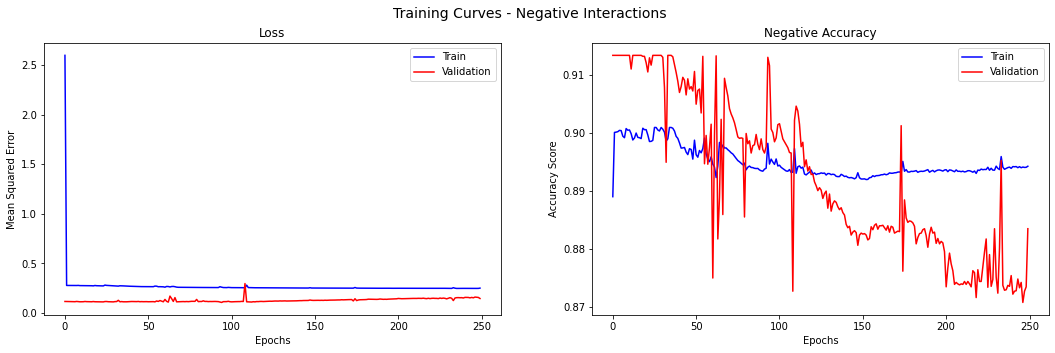

In [ ]:
# Plot training curves
fig, axs = plt.subplots(1,2,figsize=(18,5))

fig.suptitle("Training Curves - Negative Interactions", fontsize=14)

axs[0].set_title("Loss")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Mean Squared Error")
axs[0].plot(train_loss, c='b', label='Train')
axs[0].plot(val_loss, c='r', label='Validation')
axs[0].legend()

axs[1].set_title("Negative Accuracy")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy Score")
axs[1].plot(train_accuracy, c='b', label='Train')
axs[1].plot(val_accuracy, c='r', label='Validation')
axs[1].legend()

plt.show()

It seems like our two models seperately do not perform better than our single model. We thus decide to work with the simpler, thus initial model. Let us analyze the model's performance on test data.

In [ ]:
# Predicting on test data
test_loss_pos, test_loss_neg, test_accuracy_pos, test_accuracy_neg = 0,0,0,0
test_pred_pos, test_pred_neg = [],[]
model.eval()
for x,y in test_loader:
    input_, label_ = x.to(device), y.to(device)
    # Make prediction
    pred_pos, pred_neg = model(input_)
    pred_pos, pred_neg = pred_pos.reshape(-1), pred_neg.reshape(-1)

    # Compute loss and accuracy
    loss_pos = criterion(pred_pos,label_[:,0])
    loss_neg = criterion(pred_neg,label_[:,1])
    accuracy_pos = accuracy(label_[:,0].detach().cpu(),torch.round(pred_pos).detach().cpu())
    accuracy_neg = accuracy(label_[:,1].detach().cpu(),torch.round(pred_neg).detach().cpu())
    test_loss_pos += loss_pos.item() * input_.shape[0] / len(test_dataset)
    test_loss_neg += loss_neg.item() * input_.shape[0] / len(test_dataset)
    test_accuracy_pos += accuracy_pos * input_.shape[0] / len(test_dataset)
    test_accuracy_neg += accuracy_neg * input_.shape[0] / len(test_dataset)
    test_pred_pos.append(torch.round(pred_pos).detach().cpu())
    test_pred_neg.append(torch.round(pred_neg).detach().cpu())

test_pred_pos, test_pred_neg = torch.cat(test_pred_pos).numpy(), torch.cat(test_pred_neg).numpy()

In [ ]:
print("Test Positive Loss: {}".format(round(test_loss_pos,3)))
print("Test Negative Loss: {}".format(round(test_loss_neg,3)))
print("Test Positve Accuracy: {}".format(round(test_accuracy_pos,4)))
print("Test Negative Accuracy: {}".format(round(test_accuracy_neg,4)))

Test Positive Loss: 5.866
Test Negative Loss: 0.164
Test Positve Accuracy: 0.5703
Test Negative Accuracy: 0.8821


In [ ]:
# Add predictions to DataFrame
y_test["POSITIVE_SENTIMENT_pred"] = test_pred_pos
y_test["NEGATIVE_SENTIMENT_pred"] = test_pred_neg

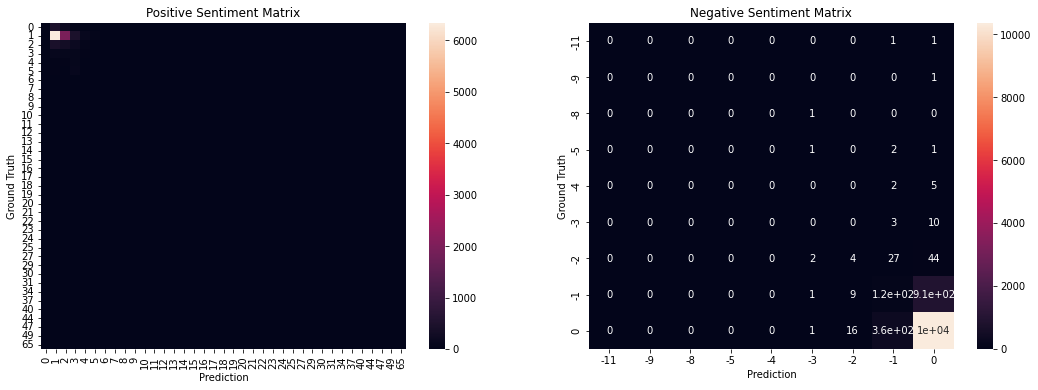

In [ ]:
# Plot Confusion Matrices
positive_lbls, negative_lbls = sorted(y_test["POSITIVE_SENTIMENT"].unique()), sorted(y_test["NEGATIVE_SENTIMENT"].unique())
confusion_mtx_pos = confusion_matrix(y_test.sort_values("POSITIVE_SENTIMENT")["POSITIVE_SENTIMENT"].to_numpy(), y_test.sort_values("POSITIVE_SENTIMENT")["POSITIVE_SENTIMENT_pred"], labels=positive_lbls)
confusion_mtx_neg = confusion_matrix(y_test.sort_values("NEGATIVE_SENTIMENT")["NEGATIVE_SENTIMENT"].to_numpy(), y_test.sort_values("NEGATIVE_SENTIMENT")["NEGATIVE_SENTIMENT_pred"], labels=negative_lbls)

fig, axs = plt.subplots(1,2,figsize=(18,6))

axs[0].set_title("Positive Sentiment Matrix")
sns.heatmap(confusion_mtx_pos, annot=False, ax=axs[0], yticklabels=positive_lbls, xticklabels=positive_lbls)
axs[0].set_ylabel("Ground Truth")
axs[0].set_xlabel("Prediction")

axs[1].set_title("Negative Sentiment Matrix")
sns.heatmap(confusion_mtx_neg, annot=True, ax=axs[1], yticklabels=negative_lbls, xticklabels=negative_lbls)
axs[1].set_ylabel("Ground Truth")
axs[1].set_xlabel("Prediction")

plt.show()

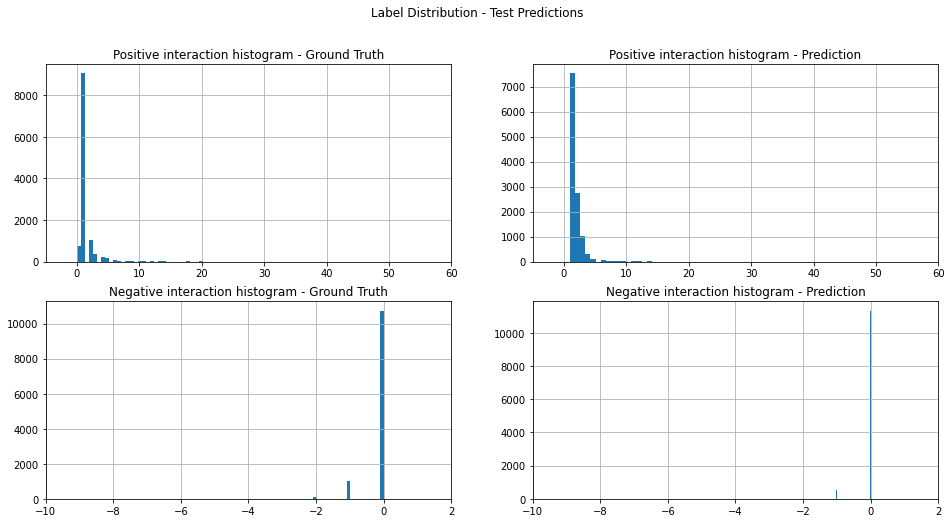

In [ ]:
# Plot histograms to compare ground truth distributions to prediction ones
fig, axs = plt.subplots(2,2, figsize=(16,8))

fig.suptitle("Label Distribution - Test Predictions")

axs[0,0].set_title("Positive interaction histogram - Ground Truth")
y_test["POSITIVE_SENTIMENT"].hist(bins=100, ax=axs[0,0])
axs[0,0].set_xlim(-5,60)

axs[0,1].set_title("Positive interaction histogram - Prediction")
y_test["POSITIVE_SENTIMENT_pred"].hist(bins=100, ax=axs[0,1])
axs[0,1].set_xlim(-5,60)

axs[1,0].set_title("Negative interaction histogram - Ground Truth")
y_test["NEGATIVE_SENTIMENT"].hist(bins=100, ax=axs[1,0])
axs[1,0].set_xlim(-10,2)

axs[1,1].set_title("Negative interaction histogram - Prediction")
y_test["NEGATIVE_SENTIMENT_pred"].hist(bins=100, ax=axs[1,1])
axs[1,1].set_xlim(-10,2)

plt.show()

Finally, results are much more precise on Negative Interactions than Positive ones (88% vs 57% accuracy scores). This can be explained by the variance of positive labels agains negative ones. Indeed, positive interactions are distributed in a much wider range (0 to 60) than negative ones (-10 to 0). Therefore, predicting positive interactions is a much more complex task than predicting negative ones. 

In any case, one can be satisified by the results produced by the model. Indeed, predictions are distributed very similarly to ground truth data. This suggests that our model is able to well generalize the behaviour of Subreddits observed in 2015 and 2016 accross time. We can thus consider our model to be sufficiently precise for the tasks we will perform in the coming section.

As a final analysis of our model's performance and to support our observations, we will plot our 2017 predictions against the ground truth 2015 and 2016 distributions. This way, if distributions are similar, we will be able to comfortably support that our model has good generalization capacity. 
Note that similarity in distributions is a statement we will make based on our observation but quantitative measures such as Kullback-Leider Divergence could be used to objectively measure them.

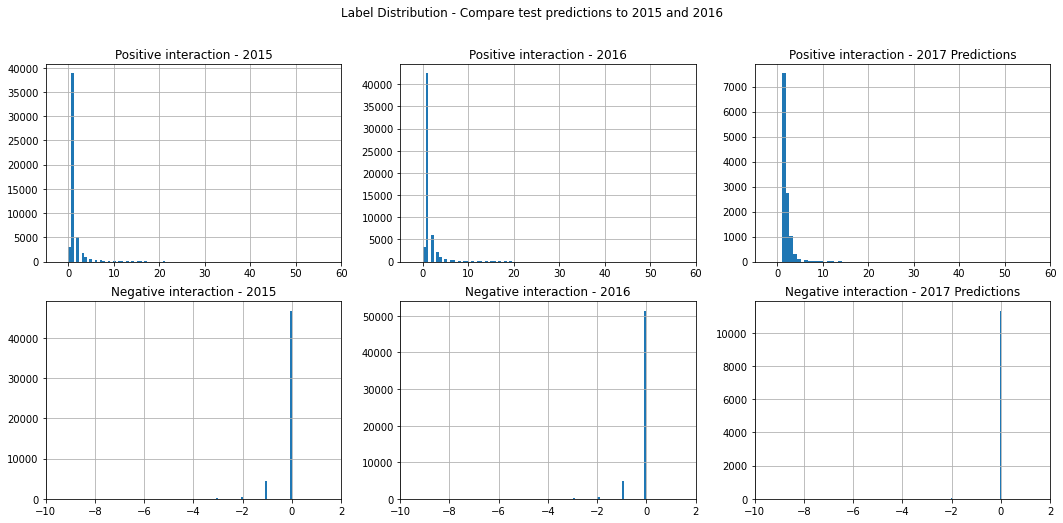

In [ ]:
# Get 2015 and 2016 data
y_2015, y_2016 = df_train[df_train["YEAR"] == 2015][labels], df_train[df_train["YEAR"] == 2016][labels]

# Plot histograms
fig, axs = plt.subplots(2,3, figsize=(18,8))

fig.suptitle("Label Distribution - Compare test predictions to 2015 and 2016")

axs[0,0].set_title("Positive interaction - 2015")
y_2015["POSITIVE_SENTIMENT"].hist(bins=300, ax=axs[0,0])
axs[0,0].set_xlim(-5,60)

axs[0,1].set_title("Positive interaction - 2016")
y_2016["POSITIVE_SENTIMENT"].hist(bins=300, ax=axs[0,1])
axs[0,1].set_xlim(-5,60)

axs[0,2].set_title("Positive interaction - 2017 Predictions")
y_test["POSITIVE_SENTIMENT_pred"].hist(bins=100, ax=axs[0,2])
axs[0,2].set_xlim(-5,60)

axs[1,0].set_title("Negative interaction - 2015")
y_2015["NEGATIVE_SENTIMENT"].hist(bins=300, ax=axs[1,0])
axs[1,0].set_xlim(-10,2)

axs[1,1].set_title("Negative interaction - 2016")
y_2016["NEGATIVE_SENTIMENT"].hist(bins=300, ax=axs[1,1])
axs[1,1].set_xlim(-10,2)

axs[1,2].set_title("Negative interaction - 2017 Predictions")
y_test["NEGATIVE_SENTIMENT_pred"].hist(bins=100, ax=axs[1,2])
axs[1,2].set_xlim(-10,2)

plt.show()

We can be satisified in the balance of our results. The three distributions are extremely similar which suggests our model is able to well generalize the interactional behaviour of Subreddits. We can thus use it to identify harmful groups which should be closely looked at for moderation. This process will be explained in the following section.

### PageRank for Toxic Sub-Reddit Identification

Consider we are at the end of 2016 and aim to identify harmful Subreddits in the coming year. This will have significant benefits in moderating negative interactions between groups on Reddit and deal with cases of cyberbullying. 

In the previous sections, we have built a model able to predict the negative and positive interactions between Subreddits in 2017. Using these results, we aim to build an automatic tool to identify which Subreddits are to be most monitored.

First observation is that the predictions of our model induce the architecture of 2 weighted graphs. First, the graph of positive interactions and second, the graph of negative interactions. For each graph, each node will be weighed by the prediction made by our model.

Applying PageRank to both of these graphs will give, for each of the Subreddits, an indicator of "how much positive and negative posts are directed towards them". This is not quite what we seek to accomplish, as we would like to quantify the behaviour of Subreddits towards others rather than the behaviour of others towards one Subreddit. We thus decide, for both of our graph structures, to invert the direction each edge. This way if a Subreddit tends to have extensive amounts of negative interactions, it will inherit from a large amount of inward edges. Then, applying PageRank to these graph structures will characterize the behaviour of Subreddits towards others.

Finally, we introduce the following $harmfulness$ coefficient:
$$
harmfulness_i = \frac{NegativePageRank_i}{PositivePageRank_i + \epsilon}
$$
where $NegativePageRank_i,PositivePageRank_i$ are the respective PageRank values of Subreddit $i$ for the Negative and Positive graphs and $ϵ$ is an arbitrarily chosen coefficient to induce a non-vanishing denominator. We choose $\epsilon = min_jPositivePageRank_j,PositivePageRank_j>0$.

This $harmfulness$ coefficient will allow us to quantify how harmful a Subreddit is with regards to others and will allow us to identify groups to moderate.

In [ ]:
# Build 2017 predicted graph of interactions
df_2017 = df_test[["SOURCE_SUBREDDIT","TARGET_SUBREDDIT","POSITIVE_SENTIMENT","NEGATIVE_SENTIMENT"]]
df_2017["POSITIVE_SENTIMENT_pred"] = y_test["POSITIVE_SENTIMENT_pred"]
df_2017["NEGATIVE_SENTIMENT_pred"] = y_test["NEGATIVE_SENTIMENT_pred"]

# Compute nodes and edges and build resulting graph
G_pos = nx.DiGraph()
G_neg = nx.DiGraph()

nodes = set(list(df_2017["SOURCE_SUBREDDIT"]) + list(df_2017["TARGET_SUBREDDIT"])) # Set of nodes
edges_pos = list(zip(list(df_2017["SOURCE_SUBREDDIT"]),list(df_2017["TARGET_SUBREDDIT"]),list(df_2017["POSITIVE_SENTIMENT_pred"]))) # List of positive edges with weights
edges_neg = list(zip(list(df_2017["SOURCE_SUBREDDIT"]),list(df_2017["TARGET_SUBREDDIT"]),list(df_2017["NEGATIVE_SENTIMENT_pred"].abs()))) # List of negative edges with weights

# Add nodes
G_pos.add_nodes_from(nodes)
G_neg.add_nodes_from(nodes)

# Add edges
G_pos.add_weighted_edges_from(edges_pos)
G_neg.add_weighted_edges_from(edges_neg)

In [ ]:
# Invert edges and compute PageRank score
G_pos = G_pos.reverse()
G_neg = G_neg.reverse()

# Compute pagerank
pagerank_pos = nx.pagerank(G_pos)
pagerank_neg = nx.pagerank(G_neg)

# Build DataFrame mapping each Subreddit to their PageRank scores
nodes = list(nodes)
pagerank_pos_lst = [pagerank_pos[node] for node in nodes]
pagerank_neg_lst = [pagerank_neg[node] for node in nodes]

df_harm = pd.DataFrame({
    "SUBREDDIT": nodes,
    "POSITIVE_PAGERANK": pagerank_pos_lst,
    "NEGATIVE_PAGERANK": pagerank_neg_lst
})

# Compute epsilon and harmfulness coefficient
epsilon = df_harm[df_harm["POSITIVE_PAGERANK"] > 0]["POSITIVE_PAGERANK"].min()
df_harm["harmfulness"] = df_harm["NEGATIVE_PAGERANK"] / (df_harm["POSITIVE_PAGERANK"] + epsilon)

In [ ]:
# Sort values with regards to harmfulness and visualize
df_harm = df_harm.sort_values("harmfulness", ascending=False)
df_harm

,SUBREDDIT,POSITIVE_PAGERANK,NEGATIVE_PAGERANK,harmfulness
1866,explainlikeimfive,0.000216,0.000309,1.116096
3657,academiceconomics,0.000061,0.000129,1.062438
1867,rebbrl,0.000061,0.000129,1.062438
3652,mongodb,0.000061,0.000129,1.062438
1872,giftournament,0.000061,0.000129,1.062438
...,...,...,...,...
69,pokemonshuffle,0.002862,0.000129,0.044206
751,tipofmypenis,0.003855,0.000170,0.043363
5476,nomorebamboozles,0.003390,0.000129,0.037442
4942,rmsfhj,0.004291,0.000129,0.029686


In [ ]:
df_harm["harmfulness"].min(),df_harm["harmfulness"].max() 

(0.020503234789707486, 1.1160957536789318)

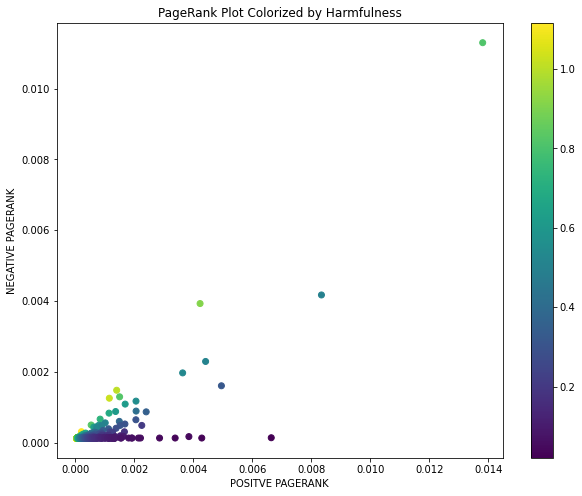

In [ ]:
# Plot a cloud of points with positive and negative pagerank values as axis
plt.figure(figsize=(10,8))
plt.title("PageRank Plot Colorized by Harmfulness")
plt.scatter(df_harm["POSITIVE_PAGERANK"],df_harm["NEGATIVE_PAGERANK"], c=df_harm["harmfulness"])
plt.xlabel("POSITVE PAGERANK")
plt.ylabel("NEGATIVE PAGERANK")
plt.colorbar()
plt.show()

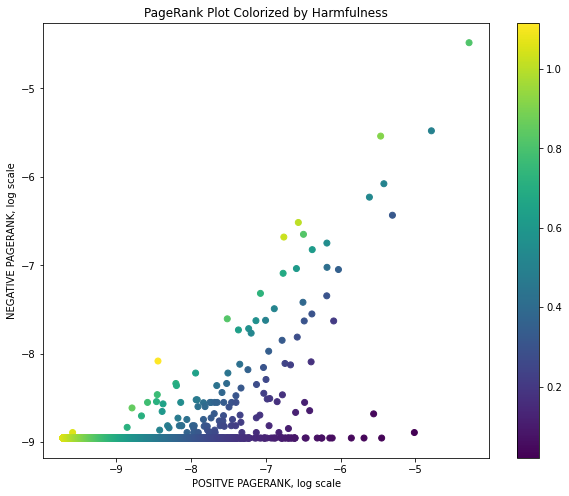

In [ ]:
# Plot same as above in logscale
plt.figure(figsize=(10,8))
plt.title("PageRank Plot Colorized by Harmfulness")
plt.scatter(np.log(df_harm["POSITIVE_PAGERANK"]),np.log(df_harm["NEGATIVE_PAGERANK"]), c=df_harm["harmfulness"])
plt.xlabel("POSITVE PAGERANK, log scale")
plt.ylabel("NEGATIVE PAGERANK, log scale")
plt.colorbar()
plt.show()

On one hand, we observe that this method is able to discriminate well Subreddits with a greater negative PageRank score than positive one. We can thus be satisfied by our results. 

On the other hand, many high harmfulness Subreddits are the ones with low amounts of interactions both on the positive and negative side. An extension to this project could be to find a $harmfulness$ function able to discriminate Subreddits with a higher activity.

As a final visualization, we plot our predictions for the 10 most and 10 less harmful Subreddits of 2017.

In [ ]:
print("10 Most Harmful Subreddits of 2017")
df_most = df_harm[:10][["SUBREDDIT","harmfulness"]]
df_most.index = np.arange(1,11)
df_most

10 Most Harmful Subreddits of 2017


,SUBREDDIT,harmfulness
1,explainlikeimfive,1.116096
2,academiceconomics,1.062438
3,rebbrl,1.062438
4,mongodb,1.062438
5,giftournament,1.062438
6,mustang,1.062438
7,ak47,1.062438
8,whatstheword,1.062438
9,fancyfollicles,1.062438
10,gorving,1.062438


In [ ]:
print("10 Less Harmful Subreddits of 2017")
df_less = df_harm[-10:][["SUBREDDIT","harmfulness"]].sort_values("harmfulness")
df_less.index = np.arange(1,11)
df_less

10 Less Harmful Subreddits of 2017


,SUBREDDIT,harmfulness
1,subredditoftheday,0.020503
2,rmsfhj,0.029686
3,nomorebamboozles,0.037442
4,tipofmypenis,0.043363
5,pokemonshuffle,0.044206
6,modhelp,0.056755
7,flyfishing,0.058581
8,place,0.064837
9,hiking,0.065370
10,askmen,0.068910
